In [21]:
##########################################################複製區塊
# import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys
import meep as mp
import numpy as np
import random
#setup some constants and parameters
M=2**21
tsim=7e-12
eps0 = 8.854187e-12
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12
deltap = np.sqrt(1/3/eps0/hbar/c)*kb
T=30000
frq_min = 0
frq_max = 3/2/np.pi
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)

#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

#define how many times to run to average the results
Ncomp= 20
nfreq =  1000
#define the starting sum of the result
Efsum = np.zeros(nfreq)
Ens = np.zeros(2*22)
resolution = 1000
dA = 1
dB = 2.4
dpml = 1.0
sz = dpml*2+dA*2+dB
cell = mp.Vector3(0, 0, sz)
pml_layers = [mp.PML(dpml)]



for i in range(Ncomp):
    
    def random_En(t):
        #generate random numbers
        M0 = np.random.normal(0,1)
        Mlp = np.random.normal(0,1,M-1)
        Nlp = np.random.normal(0,1,M-1)
        MM = np.random.normal(0,1)
    
        #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
        #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
        #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
        Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
        Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
        Eflm = np.flip(np.conjugate(Eflp))
        EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
        Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
        #we normalize Ef and compute its inverse fast fourier transform
        Efn = deltap*T/np.sqrt(tsim)*Ef
        En = np.fft.ifft(Efn)*M
        return En
    En0 = random_En(1)
    En1 = random_En(1)
    
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('a'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)
    
    
    def source0(t):
        f = int(t*2000)
        return En0[f]
    def source1(t):
        f = int(t*2000)
        return En1[f]


    sources = [mp.Source(mp.CustomSource(src_func=source0),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,-0.5*sz+dpml),
                     ),
              mp.Source(mp.CustomSource(src_func=source1),
                     component=mp.Ex,
                     center=mp.Vector3(0,0,0.5*sz-dpml),
                     )]
    
    def BlockAB(N, center):
        geometry = []
        for i in range(N):
            geometry = np.append(geometry, mp.Block(mp.Vector3(0,0,dA),
                     center=mp.Vector3(0,0,0-dA/2-dB/2),
                     material=mp.Medium(epsilon=1)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(0,0,dB),
                     center=mp.Vector3(0,0,0),
                     material=mp.Medium(epsilon=36)))
            geometry = np.append(geometry, mp.Block(mp.Vector3(0,0,dA),
                     center=mp.Vector3(0,0,dB/2+dA/2),
                     material=mp.Medium(epsilon=1)))
        geometry = geometry.tolist()
        return geometry
    sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,   
                    dimensions = 1,
                    Courant = 1,
                    resolution=resolution,
                    geometry=BlockAB(1,0))
    
    # transmitted flux
    tran_fr = mp.FluxRegion(center=mp.Vector3(0,0,random.uniform(-1.2,1.2)))
    tran = sim.add_energy(fcen, df, nfreq, tran_fr)
    
    
    sim.run(until=2090)

    tran_flux = mp.get_magnetic_energy(tran)
    Ts = []
    for i in range(nfreq):
        Ts = np.append(Ts,tran_flux[i])    
    Efsum += Ts
    
    

#average the final result
Efavg = Efsum/Ncomp

#save data to some file or reload file to write more data on it



[                    ] 0%-----------
Initializing structure...
time for choose_chunkdivision = 0.000636101 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 6.4 with resolution 1000
     block, center = (0,0,-1.7)
          size (0,0,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,0)
          size (0,0,2.4)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (36,36,36)
     block, center = (0,0,1.7)
          size (0,0,1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.00819588 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 22.126/2090.0 = 1.1% done in 4.0s, 373.8s to go
on time step 22139 (time=22.139), 0.000180681 s/step
Meep progress: 42.099000000000004/2090.0 = 2.0% done in 8.0s, 389.2s to go
on time step 42115 (time=42.115), 0.000200246 s/step
Meep progress: 63.621/2090.0 = 3.0% done in 12.0s, 382.2s to go
on time step 63646 (time=63.646), 0.000185779 s/step
Meep progress: 84.897/2090.0 = 4.1% done in 16.0s, 377.9s to go
on time step 84929 (time=84.929), 0.000187945 s/step
Meep progress: 102.899/2090.0 = 4.9% done in 20.0s, 386.2s to go
on time step 102931 (time=102.931), 0.000222202 s/step
Meep progress: 120.361/2090.0 = 5.8% done in 24.0s, 392.8s to go
on time step 120391 (time=120.391), 0.000229101 s/step
Meep progress: 140.706/2090.0 = 6.7% done in 28.0s, 387.9s to go
on time step 140744 (time=140.744), 0.00019654 s/step
Meep progress: 159.263/2090.0 = 7.6% done in 32.0s, 387.9s to go
on time step 159303 (time=159.303), 0.000215534 s/step
Meep progress: 178.196/2090.0 = 8.5% done i

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 21.699/2090.0 = 1.0% done in 4.0s, 381.3s to go
on time step 21943 (time=21.943), 0.000182293 s/step
Meep progress: 43.015/2090.0 = 2.1% done in 8.0s, 380.7s to go
on time step 43223 (time=43.223), 0.000187976 s/step
Meep progress: 63.493/2090.0 = 3.0% done in 12.0s, 383.0s to go
on time step 63735 (time=63.735), 0.000195013 s/step
Meep progress: 82.618/2090.0 = 4.0% done in 16.0s, 388.8s to go
on time step 82844 (time=82.844), 0.00020933 s/step
Meep progress: 104.116/2090.0 = 5.0% done in 20.0s, 381.5s to go
on time step 104388 (time=104.388), 0.000185667 s/step
Meep progress: 126.10000000000001/2090.0 = 6.0% done in 24.0s, 373.8s to go
on time step 126370 (time=126.37), 0.000181968 s/step
Meep progress: 148.092/2090.0 = 7.1% done in 28.0s, 367.2s to go
on time step 148367 (time=148.367), 0.000181849 s/step
Meep progress: 170.011/2090.0 = 8.1% done in 32.0s, 361.4s to go
on time step 170290 (time=170.29), 0.000182464 s/step
Meep progress: 191.892/2090.0 = 9.2% done in 3

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 22.39/2090.0 = 1.1% done in 4.0s, 369.4s to go
on time step 22418 (time=22.418), 0.000178433 s/step
Meep progress: 44.176/2090.0 = 2.1% done in 8.0s, 370.5s to go
on time step 44205 (time=44.205), 0.0001836 s/step
Meep progress: 63.875/2090.0 = 3.1% done in 12.0s, 380.6s to go
on time step 63907 (time=63.907), 0.000203029 s/step
Meep progress: 85.66/2090.0 = 4.1% done in 16.0s, 374.4s to go
on time step 85701 (time=85.701), 0.000183544 s/step
Meep progress: 107.541/2090.0 = 5.1% done in 20.0s, 368.7s to go
on time step 107586 (time=107.586), 0.000182779 s/step
Meep progress: 129.436/2090.0 = 6.2% done in 24.0s, 363.5s to go
on time step 129489 (time=129.489), 0.000182631 s/step
Meep progress: 151.311/2090.0 = 7.2% done in 28.0s, 358.8s to go
on time step 151368 (time=151.368), 0.000182829 s/step
Meep progress: 172.747/2090.0 = 8.3% done in 32.0s, 355.2s to go
on time step 172808 (time=172.808), 0.000186571 s/step
Meep progress: 193.65200000000002/2090.0 = 9.3% done in 36

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 21.658/2090.0 = 1.0% done in 4.0s, 382.0s to go
on time step 21682 (time=21.682), 0.000184485 s/step
Meep progress: 42.888/2090.0 = 2.1% done in 8.0s, 381.9s to go
on time step 42917 (time=42.917), 0.000188376 s/step
Meep progress: 63.93/2090.0 = 3.1% done in 12.0s, 380.3s to go
on time step 63962 (time=63.962), 0.000190069 s/step
Meep progress: 85.09/2090.0 = 4.1% done in 16.0s, 377.0s to go
on time step 85126 (time=85.126), 0.000189002 s/step
Meep progress: 106.131/2090.0 = 5.1% done in 20.0s, 373.9s to go
on time step 106172 (time=106.172), 0.000190062 s/step
Meep progress: 127.268/2090.0 = 6.1% done in 24.0s, 370.1s to go
on time step 127313 (time=127.313), 0.000189208 s/step
Meep progress: 147.572/2090.0 = 7.1% done in 28.0s, 368.6s to go
on time step 147617 (time=147.617), 0.000197009 s/step
Meep progress: 168.428/2090.0 = 8.1% done in 32.0s, 365.1s to go
on time step 168486 (time=168.486), 0.000191679 s/step
Meep progress: 187.501/2090.0 = 9.0% done in 36.0s, 365.

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 21.626/2090.0 = 1.0% done in 4.0s, 382.6s to go
on time step 21648 (time=21.648), 0.000184781 s/step
Meep progress: 42.417/2090.0 = 2.0% done in 8.0s, 386.2s to go
on time step 42438 (time=42.438), 0.000192401 s/step
Meep progress: 63.572/2090.0 = 3.0% done in 12.0s, 382.5s to go
on time step 63597 (time=63.597), 0.000189046 s/step
Meep progress: 84.813/2090.0 = 4.1% done in 16.0s, 378.3s to go
on time step 84841 (time=84.841), 0.000188291 s/step
Meep progress: 106.001/2090.0 = 5.1% done in 20.0s, 374.3s to go
on time step 106031 (time=106.031), 0.00018877 s/step
Meep progress: 126.916/2090.0 = 6.1% done in 24.0s, 371.2s to go
on time step 126952 (time=126.952), 0.000191201 s/step
Meep progress: 148.726/2090.0 = 7.1% done in 28.0s, 365.5s to go
on time step 148767 (time=148.767), 0.000183366 s/step
Meep progress: 170.483/2090.0 = 8.2% done in 32.0s, 360.3s to go
on time step 170527 (time=170.527), 0.000183831 s/step
Meep progress: 192.219/2090.0 = 9.2% done in 36.0s, 355

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 22.516000000000002/2090.0 = 1.1% done in 4.0s, 367.3s to go
on time step 22525 (time=22.525), 0.000177583 s/step
Meep progress: 43.735/2090.0 = 2.1% done in 8.0s, 374.3s to go
on time step 43745 (time=43.745), 0.000188502 s/step
Meep progress: 64.20700000000001/2090.0 = 3.1% done in 12.0s, 378.6s to go
on time step 64218 (time=64.218), 0.000195381 s/step
Meep progress: 84.641/2090.0 = 4.0% done in 16.0s, 379.1s to go
on time step 84654 (time=84.654), 0.000195738 s/step
Meep progress: 104.932/2090.0 = 5.0% done in 20.0s, 378.4s to go
on time step 104946 (time=104.946), 0.000197131 s/step
Meep progress: 125.327/2090.0 = 6.0% done in 24.0s, 376.2s to go
on time step 125346 (time=125.346), 0.00019608 s/step
Meep progress: 145.904/2090.0 = 7.0% done in 28.0s, 373.1s to go
on time step 145924 (time=145.924), 0.000194387 s/step
Meep progress: 166.413/2090.0 = 8.0% done in 32.0s, 369.9s to go
on time step 166435 (time=166.435), 0.000195021 s/step
Meep progress: 186.7950000000000

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 22.579/2090.0 = 1.1% done in 4.0s, 366.3s to go
on time step 22589 (time=22.589), 0.000177083 s/step
Meep progress: 44.574/2090.0 = 2.1% done in 8.0s, 367.1s to go
on time step 44587 (time=44.587), 0.000181841 s/step
Meep progress: 66.537/2090.0 = 3.2% done in 12.0s, 364.9s to go
on time step 66553 (time=66.553), 0.000182106 s/step
Meep progress: 88.361/2090.0 = 4.2% done in 16.0s, 362.5s to go
on time step 88379 (time=88.379), 0.000183271 s/step
Meep progress: 110.289/2090.0 = 5.3% done in 20.0s, 359.0s to go
on time step 110309 (time=110.309), 0.000182403 s/step
Meep progress: 132.18/2090.0 = 6.3% done in 24.0s, 355.5s to go
on time step 132206 (time=132.206), 0.000182674 s/step
Meep progress: 154.143/2090.0 = 7.4% done in 28.0s, 351.7s to go
on time step 154174 (time=154.174), 0.00018209 s/step
Meep progress: 176.113/2090.0 = 8.4% done in 32.0s, 347.8s to go
on time step 176146 (time=176.146), 0.000182053 s/step
Meep progress: 197.654/2090.0 = 9.5% done in 36.0s, 344.

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 19.187/2090.0 = 0.9% done in 4.0s, 431.7s to go
on time step 19204 (time=19.204), 0.000208295 s/step
Meep progress: 40.253/2090.0 = 1.9% done in 8.0s, 407.4s to go
on time step 40279 (time=40.279), 0.00018982 s/step
Meep progress: 61.61/2090.0 = 2.9% done in 12.0s, 395.1s to go
on time step 61646 (time=61.646), 0.000187211 s/step
Meep progress: 82.766/2090.0 = 4.0% done in 16.0s, 388.0s to go
on time step 82808 (time=82.808), 0.000189024 s/step
Meep progress: 104.298/2090.0 = 5.0% done in 20.0s, 380.8s to go
on time step 104345 (time=104.345), 0.000185733 s/step
Meep progress: 124.21300000000001/2090.0 = 5.9% done in 24.0s, 379.8s to go
on time step 124257 (time=124.257), 0.00020089 s/step
Meep progress: 145.512/2090.0 = 7.0% done in 28.0s, 374.2s to go
on time step 145571 (time=145.571), 0.000187673 s/step
Meep progress: 166.266/2090.0 = 8.0% done in 32.0s, 370.3s to go
on time step 166331 (time=166.331), 0.00019268 s/step
Meep progress: 187.424/2090.0 = 9.0% done in 36

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 22.005/2090.0 = 1.1% done in 4.0s, 375.9s to go
on time step 22015 (time=22.015), 0.000181705 s/step
Meep progress: 40.382/2090.0 = 1.9% done in 8.0s, 406.1s to go
on time step 40398 (time=40.398), 0.000217595 s/step
Meep progress: 61.25/2090.0 = 2.9% done in 12.0s, 397.5s to go
on time step 61272 (time=61.272), 0.000191632 s/step
Meep progress: 81.891/2090.0 = 3.9% done in 16.0s, 392.4s to go
on time step 81918 (time=81.918), 0.000193743 s/step
Meep progress: 102.072/2090.0 = 4.9% done in 20.0s, 389.5s to go
on time step 102097 (time=102.097), 0.000198226 s/step
Meep progress: 122.753/2090.0 = 5.9% done in 24.0s, 384.6s to go
on time step 122783 (time=122.783), 0.000193369 s/step
Meep progress: 139.17000000000002/2090.0 = 6.7% done in 28.0s, 392.5s to go
on time step 139201 (time=139.201), 0.000243645 s/step
Meep progress: 157.34/2090.0 = 7.5% done in 32.0s, 393.1s to go
on time step 157373 (time=157.373), 0.00022012 s/step
Meep progress: 175.89600000000002/2090.0 = 8.4

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 22.51/2090.0 = 1.1% done in 4.0s, 367.4s to go
on time step 22536 (time=22.536), 0.0001775 s/step
Meep progress: 44.477000000000004/2090.0 = 2.1% done in 8.0s, 367.9s to go
on time step 44509 (time=44.509), 0.000182048 s/step
Meep progress: 66.426/2090.0 = 3.2% done in 12.0s, 365.6s to go
on time step 66461 (time=66.461), 0.000182218 s/step
Meep progress: 88.362/2090.0 = 4.2% done in 16.0s, 362.4s to go
on time step 88404 (time=88.404), 0.000182298 s/step
Meep progress: 109.559/2090.0 = 5.2% done in 20.0s, 361.5s to go
on time step 109605 (time=109.605), 0.000188674 s/step
Meep progress: 131.268/2090.0 = 6.3% done in 24.0s, 358.1s to go
on time step 131321 (time=131.321), 0.000184198 s/step
Meep progress: 153.281/2090.0 = 7.3% done in 28.0s, 353.8s to go
on time step 153338 (time=153.338), 0.000181686 s/step
Meep progress: 175.22/2090.0 = 8.4% done in 32.0s, 349.7s to go
on time step 175279 (time=175.279), 0.000182308 s/step
Meep progress: 196.942/2090.0 = 9.4% done in 3

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 22.543/2090.0 = 1.1% done in 4.0s, 366.9s to go
on time step 22551 (time=22.551), 0.000177378 s/step
Meep progress: 44.129/2090.0 = 2.1% done in 8.0s, 370.9s to go
on time step 44138 (time=44.138), 0.000185302 s/step
Meep progress: 65.247/2090.0 = 3.1% done in 12.0s, 372.4s to go
on time step 65260 (time=65.26), 0.00018938 s/step
Meep progress: 87.11/2090.0 = 4.2% done in 16.0s, 367.9s to go
on time step 87125 (time=87.125), 0.000182945 s/step
Meep progress: 109.001/2090.0 = 5.2% done in 20.0s, 363.5s to go
on time step 109018 (time=109.018), 0.00018271 s/step
Meep progress: 130.921/2090.0 = 6.3% done in 24.0s, 359.1s to go
on time step 130940 (time=130.94), 0.000182474 s/step
Meep progress: 152.211/2090.0 = 7.3% done in 28.0s, 356.5s to go
on time step 152233 (time=152.233), 0.00018786 s/step
Meep progress: 173.422/2090.0 = 8.3% done in 32.0s, 353.7s to go
on time step 173446 (time=173.446), 0.000188566 s/step
Meep progress: 194.561/2090.0 = 9.3% done in 36.0s, 350.7s t

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 20.998/2090.0 = 1.0% done in 4.0s, 394.1s to go
on time step 21009 (time=21.009), 0.000190403 s/step
Meep progress: 41.525/2090.0 = 2.0% done in 8.0s, 394.7s to go
on time step 41540 (time=41.54), 0.000194832 s/step
Meep progress: 62.166000000000004/2090.0 = 3.0% done in 12.0s, 391.4s to go
on time step 62181 (time=62.181), 0.000193793 s/step
Meep progress: 82.708/2090.0 = 4.0% done in 16.0s, 388.3s to go
on time step 82725 (time=82.725), 0.000194711 s/step
Meep progress: 103.524/2090.0 = 5.0% done in 20.0s, 383.8s to go
on time step 103545 (time=103.545), 0.000192128 s/step
Meep progress: 124.264/2090.0 = 5.9% done in 24.0s, 379.7s to go
on time step 124287 (time=124.287), 0.00019285 s/step
Meep progress: 142.725/2090.0 = 6.8% done in 28.0s, 382.0s to go
on time step 142747 (time=142.747), 0.000216692 s/step
Meep progress: 160.312/2090.0 = 7.7% done in 32.0s, 385.2s to go
on time step 160336 (time=160.336), 0.000227418 s/step
Meep progress: 177.592/2090.0 = 8.5% done in

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 20.103/2090.0 = 1.0% done in 4.0s, 411.9s to go
on time step 20112 (time=20.112), 0.000198887 s/step
Meep progress: 40.57/2090.0 = 1.9% done in 8.0s, 404.1s to go
on time step 40580 (time=40.58), 0.000195429 s/step
Meep progress: 59.59/2090.0 = 2.9% done in 12.0s, 408.9s to go
on time step 59604 (time=59.604), 0.000210266 s/step
Meep progress: 80.349/2090.0 = 3.8% done in 16.0s, 400.2s to go
on time step 80365 (time=80.365), 0.00019267 s/step
Meep progress: 101.262/2090.0 = 4.8% done in 20.0s, 392.8s to go
on time step 101281 (time=101.281), 0.000191244 s/step
Meep progress: 122.114/2090.0 = 5.8% done in 24.0s, 386.8s to go
on time step 122134 (time=122.134), 0.000191826 s/step
Meep progress: 142.685/2090.0 = 6.8% done in 28.0s, 382.1s to go
on time step 142709 (time=142.709), 0.000194416 s/step
Meep progress: 163.143/2090.0 = 7.8% done in 32.0s, 378.0s to go
on time step 163170 (time=163.17), 0.000195499 s/step
Meep progress: 183.42600000000002/2090.0 = 8.8% done in 36.

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 21.164/2090.0 = 1.0% done in 4.0s, 391.0s to go
on time step 21187 (time=21.187), 0.000188797 s/step
Meep progress: 41.982/2090.0 = 2.0% done in 8.0s, 390.3s to go
on time step 42011 (time=42.011), 0.000192093 s/step
Meep progress: 62.813/2090.0 = 3.0% done in 12.0s, 387.3s to go
on time step 62848 (time=62.848), 0.000191969 s/step
Meep progress: 82.47800000000001/2090.0 = 3.9% done in 16.0s, 389.5s to go
on time step 82511 (time=82.511), 0.000203434 s/step
Meep progress: 100.257/2090.0 = 4.8% done in 20.0s, 396.9s to go
on time step 100300 (time=100.3), 0.000224868 s/step
Meep progress: 118.00200000000001/2090.0 = 5.6% done in 24.0s, 401.1s to go
on time step 118050 (time=118.05), 0.000225364 s/step
Meep progress: 138.863/2090.0 = 6.6% done in 28.0s, 393.4s to go
on time step 138923 (time=138.923), 0.000191644 s/step
Meep progress: 157.27700000000002/2090.0 = 7.5% done in 32.0s, 393.2s to go
on time step 157338 (time=157.338), 0.000217223 s/step
Meep progress: 175.077/2

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 21.863/2090.0 = 1.0% done in 4.0s, 378.4s to go
on time step 21887 (time=21.887), 0.000182765 s/step
Meep progress: 43.083/2090.0 = 2.1% done in 8.0s, 380.1s to go
on time step 43111 (time=43.111), 0.000188482 s/step
Meep progress: 63.969/2090.0 = 3.1% done in 12.0s, 380.1s to go
on time step 63999 (time=63.999), 0.000191498 s/step
Meep progress: 85.038/2090.0 = 4.1% done in 16.0s, 377.2s to go
on time step 85069 (time=85.069), 0.00018985 s/step
Meep progress: 106.262/2090.0 = 5.1% done in 20.0s, 373.4s to go
on time step 106300 (time=106.3), 0.000188409 s/step
Meep progress: 127.375/2090.0 = 6.1% done in 24.0s, 369.8s to go
on time step 127420 (time=127.42), 0.000189397 s/step
Meep progress: 148.587/2090.0 = 7.1% done in 28.0s, 365.9s to go
on time step 148636 (time=148.636), 0.000188544 s/step
Meep progress: 169.768/2090.0 = 8.1% done in 32.0s, 362.0s to go
on time step 169822 (time=169.822), 0.000188805 s/step
Meep progress: 190.835/2090.0 = 9.1% done in 36.0s, 358.3s

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 19.21/2090.0 = 0.9% done in 4.0s, 431.2s to go
on time step 19217 (time=19.217), 0.000208156 s/step
Meep progress: 37.349000000000004/2090.0 = 1.8% done in 8.0s, 439.7s to go
on time step 37359 (time=37.359), 0.000220492 s/step
Meep progress: 55.293/2090.0 = 2.6% done in 12.0s, 441.6s to go
on time step 55306 (time=55.306), 0.00022289 s/step
Meep progress: 74.884/2090.0 = 3.6% done in 16.0s, 430.6s to go
on time step 74897 (time=74.897), 0.000204185 s/step
Meep progress: 94.824/2090.0 = 4.5% done in 20.0s, 420.8s to go
on time step 94844 (time=94.844), 0.000200535 s/step
Meep progress: 116.098/2090.0 = 5.6% done in 24.0s, 408.1s to go
on time step 116120 (time=116.12), 0.000188014 s/step
Meep progress: 136.36/2090.0 = 6.5% done in 28.0s, 401.2s to go
on time step 136382 (time=136.382), 0.000197417 s/step
Meep progress: 154.175/2090.0 = 7.4% done in 32.0s, 401.8s to go
on time step 154198 (time=154.198), 0.000224528 s/step
Meep progress: 171.913/2090.0 = 8.2% done in 36.0

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 22.192/2090.0 = 1.1% done in 4.0s, 372.7s to go
on time step 22200 (time=22.2), 0.000180183 s/step
Meep progress: 43.569/2090.0 = 2.1% done in 8.0s, 375.8s to go
on time step 43580 (time=43.58), 0.000187093 s/step
Meep progress: 64.913/2090.0 = 3.1% done in 12.0s, 374.4s to go
on time step 64926 (time=64.926), 0.000187392 s/step
Meep progress: 85.96600000000001/2090.0 = 4.1% done in 16.0s, 373.0s to go
on time step 85982 (time=85.982), 0.000189976 s/step
Meep progress: 104.575/2090.0 = 5.0% done in 20.0s, 379.7s to go
on time step 104589 (time=104.589), 0.00021498 s/step
Meep progress: 123.361/2090.0 = 5.9% done in 24.0s, 382.6s to go
on time step 123383 (time=123.383), 0.000212843 s/step
Meep progress: 144.526/2090.0 = 6.9% done in 28.0s, 376.9s to go
on time step 144547 (time=144.547), 0.000189 s/step
Meep progress: 164.366/2090.0 = 7.9% done in 32.0s, 374.9s to go
on time step 164384 (time=164.384), 0.000201645 s/step
Meep progress: 182.184/2090.0 = 8.7% done in 36.0s

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 19.607/2090.0 = 0.9% done in 4.0s, 422.4s to go
on time step 19617 (time=19.617), 0.000203908 s/step
Meep progress: 38.757/2090.0 = 1.9% done in 8.0s, 423.4s to go
on time step 38770 (time=38.77), 0.000208851 s/step
Meep progress: 60.058/2090.0 = 2.9% done in 12.0s, 405.6s to go
on time step 60073 (time=60.073), 0.000187774 s/step
Meep progress: 81.37/2090.0 = 3.9% done in 16.0s, 395.0s to go
on time step 81387 (time=81.387), 0.000187672 s/step
Meep progress: 102.11/2090.0 = 4.9% done in 20.0s, 389.4s to go
on time step 102130 (time=102.13), 0.000192841 s/step
Meep progress: 120.84700000000001/2090.0 = 5.8% done in 24.0s, 391.1s to go
on time step 120863 (time=120.863), 0.000213529 s/step
Meep progress: 138.37/2090.0 = 6.6% done in 28.0s, 394.9s to go
on time step 138391 (time=138.391), 0.000228216 s/step
Meep progress: 157.056/2090.0 = 7.5% done in 32.0s, 393.8s to go
on time step 157077 (time=157.077), 0.000214075 s/step
Meep progress: 175.13/2090.0 = 8.4% done in 36.0

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 22.394000000000002/2090.0 = 1.1% done in 4.0s, 369.3s to go
on time step 22402 (time=22.402), 0.000178562 s/step
Meep progress: 44.262/2090.0 = 2.1% done in 8.0s, 369.8s to go
on time step 44272 (time=44.272), 0.000182899 s/step
Meep progress: 66.112/2090.0 = 3.2% done in 12.0s, 367.4s to go
on time step 66125 (time=66.125), 0.000183048 s/step
Meep progress: 86.956/2090.0 = 4.2% done in 16.0s, 368.6s to go
on time step 86972 (time=86.972), 0.000191876 s/step
Meep progress: 108.675/2090.0 = 5.2% done in 20.0s, 364.6s to go
on time step 108692 (time=108.692), 0.000184164 s/step
Meep progress: 130.558/2090.0 = 6.2% done in 24.0s, 360.2s to go
on time step 130579 (time=130.579), 0.000182765 s/step
Meep progress: 152.511/2090.0 = 7.3% done in 28.0s, 355.7s to go
on time step 152534 (time=152.534), 0.000182196 s/step
Meep progress: 174.362/2090.0 = 8.3% done in 32.0s, 351.6s to go
on time step 174387 (time=174.387), 0.000183047 s/step
Meep progress: 196.155/2090.0 = 9.4% done 

FloatProgress(value=0.0, description='0% done ', max=2090.0)

Meep progress: 21.953/2090.0 = 1.1% done in 4.0s, 376.8s to go
on time step 21968 (time=21.968), 0.000182089 s/step
Meep progress: 43.965/2090.0 = 2.1% done in 8.0s, 372.3s to go
on time step 43983 (time=43.983), 0.000181701 s/step
Meep progress: 65.97/2090.0 = 3.2% done in 12.0s, 368.2s to go
on time step 65991 (time=65.991), 0.000181759 s/step
Meep progress: 87.953/2090.0 = 4.2% done in 16.0s, 364.2s to go
on time step 87978 (time=87.978), 0.000181928 s/step
Meep progress: 110.007/2090.0 = 5.3% done in 20.0s, 360.0s to go
on time step 110034 (time=110.034), 0.000181358 s/step
Meep progress: 132.032/2090.0 = 6.3% done in 24.0s, 355.9s to go
on time step 132062 (time=132.062), 0.000181592 s/step
Meep progress: 153.93/2090.0 = 7.4% done in 28.0s, 352.2s to go
on time step 153961 (time=153.961), 0.000182663 s/step
Meep progress: 175.935/2090.0 = 8.4% done in 32.0s, 348.2s to go
on time step 175969 (time=175.969), 0.000181758 s/step
Meep progress: 197.653/2090.0 = 9.5% done in 36.0s, 344.

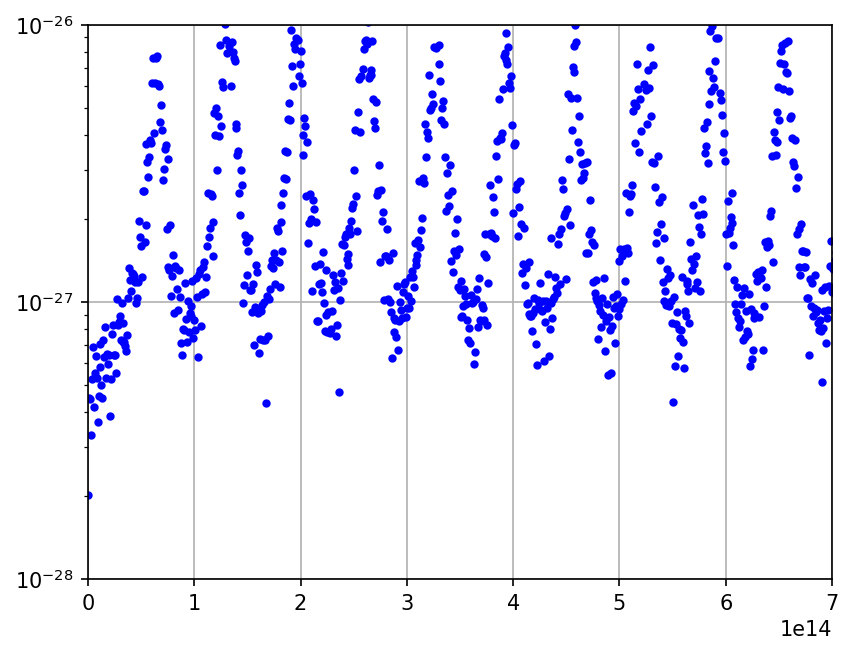

In [31]:
plt.figure(dpi=150)
freqs = np.linspace(0,0.9e15,1000)
plt.plot(freqs,Efavg*tsim*eps0*4*np.pi/2**21,'b''.')
plt.xlim(0,0.7e15)
plt.yscale("log")
plt.ylim(1e-28,100e-28)
plt.grid()
plt.savefig('30000_2.4um_photonic_crystal.png')
plt.show()
np.savez("30000_2.4um_photonic_crystal.npz", Efavg_30000_2400 = Efavg)

In [ ]:
from PIL import Image

def transPNG(srcImageName, dstImageName):
    img = Image.open(srcImageName)
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = list()
    for item in datas:
        if item[0] > 225 and item[1] > 225 and item[2] > 225:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
            
    img.putdata(newData)
    img.save(dstImageName, "PNG")
transPNG('test_detector_photonic_crystal_50000.png','trans_test_detector_photonic_crystal_50000.png')